# Parameter Reduction Methods Experiments on CNN Trained on MNIST Dataset

# Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable
import torch.nn.utils.prune as prune
from torchvision.transforms.autoaugment import TrivialAugmentWide

import numpy as np
import math
import cv2
import time, datetime
from prettytable import PrettyTable
from numpy.linalg import svd

In [2]:
# Define the device to train on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load data

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 92915545.50it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105335385.93it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28088830.48it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21550371.91it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [5]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [6]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f4444be3a00>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f4444be3be0>}

In [7]:
len(loaders["test"]), len(loaders["train"])

(100, 600)

# Utils (training, testing and visualization functions)

In [8]:
def train(cnn, optimizer, loss_func, loaders, num_epochs):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        running_loss = 0.0
        visualize = True

        for i, (images, labels) in tqdm(enumerate(loaders['train']), total=len(loaders['train'])):
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y

            output = cnn(b_x)[0]
            b_y = b_y.to(device)
            output = output.to(device)     
            loss = loss_func(output, b_y)
            
            # clear gradients 
            optimizer.zero_grad()           
            
            # backpropagation
            loss.backward()  

            optimizer.step()     

            running_loss += loss.item()     
                
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, running_loss/len(loaders['train'])))

In [9]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def test(cnn, loaders):
    # Test the model
    cnn.eval()
    with torch.no_grad():
        all_labels = []
        all_preds = []
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)

            preds = torch.max(test_output, 1)[1].data.squeeze().cpu().numpy()
            labels = labels.cpu().numpy()
            
            all_labels.extend(labels)
            all_preds.extend(preds)
        
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

    # print('Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    print('Precision on the 10000 test images: %.4f' % precision)
    print('Recall on the 10000 test images: %.4f' % recall)
    print('F1 score on the 10000 test images: %.4f' % f1)

In [10]:
def visualize_conv(conv_layer):
    fig, axs = plt.subplots(1, 2)

    k = 10
    sample_image = test_data[k]
    axs[0].imshow(sample_image[0][0], cmap='gray')

    conv_output = conv_layer(sample_image[0])
    axs[1].imshow(conv_output[0].cpu().detach().numpy(), cmap='gray')

    plt.show()

# Original CNN

## Model

In [11]:
class MNISTCNN(nn.Module):
    def __init__(self):
        super(MNISTCNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,          
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),  
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x, visualize=False):
        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x

## Training

In [12]:
cnn = MNISTCNN()
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:51<00:00, 11.65it/s]

Epoch [1/10], Loss: 0.1798



100%|██████████| 600/600 [00:38<00:00, 15.71it/s]

Epoch [2/10], Loss: 0.0673



100%|██████████| 600/600 [00:38<00:00, 15.57it/s]

Epoch [3/10], Loss: 0.0591



100%|██████████| 600/600 [00:37<00:00, 15.81it/s]

Epoch [4/10], Loss: 0.0565



100%|██████████| 600/600 [00:36<00:00, 16.32it/s]

Epoch [5/10], Loss: 0.0543



100%|██████████| 600/600 [00:36<00:00, 16.35it/s]

Epoch [6/10], Loss: 0.0515



100%|██████████| 600/600 [00:37<00:00, 15.98it/s]

Epoch [7/10], Loss: 0.0479



100%|██████████| 600/600 [00:37<00:00, 15.88it/s]

Epoch [8/10], Loss: 0.0481



100%|██████████| 600/600 [00:38<00:00, 15.63it/s]

Epoch [9/10], Loss: 0.0446



100%|██████████| 600/600 [00:37<00:00, 15.84it/s]

Epoch [10/10], Loss: 0.0461
Training time: 391


## Testing

In [13]:
test(cnn, loaders)

Precision on the 10000 test images: 0.9832
Recall on the 10000 test images: 0.9831
F1 score on the 10000 test images: 0.9831


## Visualization

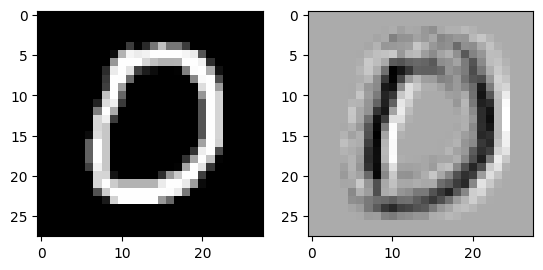

In [14]:
conv_layer = nn.Conv2d(
                in_channels=1,              
                out_channels=1,            
                kernel_size=5,       
                stride=1,                   
                padding=2,                  
            )
visualize_conv(conv_layer)

# CNN with fractional filters

## Model

In [15]:
class FractionalConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(FractionalConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Initializing the learnable parameters

        # In A < 1, because the gamma function is not defined for negative integers or zero.
        # In the paper, they mention using a regularization term 
        # to ensure that A is greater than or equal to 1, which would avoid this issue.
        self.A = torch.randn(self.out_channels, self.in_channels)
        self.A = nn.Parameter(torch.abs(self.A) + 1)

        self.sigma = nn.Parameter(torch.randn(self.out_channels, self.in_channels).abs())
        self.x0 = nn.Parameter(torch.randn(self.out_channels, self.in_channels))
        self.y0 = nn.Parameter(torch.randn(self.out_channels, self.in_channels))
        self.a = nn.Parameter(torch.rand(self.out_channels, self.in_channels) * 2)
        self.b = nn.Parameter(torch.rand(self.out_channels, self.in_channels) * 2)

        self.weights = None
        self.compute_weights()

    def compute_weights(self):
        # Computing weights
        weights = torch.zeros(self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)
        dx = self._fractional_derivative(self.a, self.A, self.sigma, self.x0)
        dy = self._fractional_derivative(self.a, self.A, self.sigma, self.y0)

        kernel = torch.einsum('abc,abd->acbd', dx, dy)
        weights = kernel.reshape(dx.shape[0], dx.shape[1], dx.shape[2], dy.shape[2])

        self.weights = weights.to(device)

    def forward(self, x):
        self.weights = self.weights.clone().detach()
        x = x.to(device)
        out = F.conv2d(x, self.weights, stride=self.stride, padding=self.padding)
        return out

    def _fractional_derivative(self, alpha, A, sigma, x0):
        N = 10
        h = torch.tensor(1 / self.kernel_size).repeat(self.out_channels, self.in_channels, self.kernel_size)

        def gamma_func(a):
            return torch.exp(torch.lgamma(a))

        def G(x):
            return torch.exp(-(torch.square(x-x0))/torch.square(sigma))
        
        def f(x, n):
            return (gamma_func(alpha + 1) * G(x)) / ((-1)**n * gamma_func(n+1) * gamma_func(1-n+alpha))

        dx = torch.zeros (self.out_channels, self.in_channels, self.kernel_size)
        for x in range(1, self.kernel_size+1):
            x = torch.tensor(x).repeat(self.out_channels, self.in_channels)
            sum_term = 0
            for n in range(N+1):
                n = torch.tensor(n).repeat(self.out_channels, self.in_channels)
                sum_term += f(x, n)

            dx[..., x-1] = sum_term

        dx = dx.to(device)
        h = h.to(device)
        A = A.unsqueeze(2).repeat(1, 1, self.kernel_size)
        A = A.to(device)
        dx = (A / h) * dx

        return dx

In [16]:
class MNISTCNN_frac(nn.Module):
    def __init__(self):
        super(MNISTCNN_frac, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,          
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(
            FractionalConv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,           
                stride=1,                   
                padding=2,                  
            ),    
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10).to(device)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        x.to(device)
        output = self.out(x)
        return output, x

## Training

In [17]:
cnn_frac = MNISTCNN_frac()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_frac.parameters(), lr = 0.01)   

start = datetime.datetime.now()
train(cnn_frac, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:28<00:00, 20.90it/s]

Epoch [1/10], Loss: 51.4320



100%|██████████| 600/600 [00:20<00:00, 28.90it/s]

Epoch [2/10], Loss: 2.3018



100%|██████████| 600/600 [00:21<00:00, 27.69it/s]

Epoch [3/10], Loss: 2.3019



100%|██████████| 600/600 [00:21<00:00, 27.52it/s]

Epoch [4/10], Loss: 2.3019



100%|██████████| 600/600 [00:20<00:00, 29.01it/s]

Epoch [5/10], Loss: 2.3018



100%|██████████| 600/600 [00:21<00:00, 27.73it/s]

Epoch [6/10], Loss: 2.3019



100%|██████████| 600/600 [00:21<00:00, 28.03it/s]

Epoch [7/10], Loss: 2.3020



100%|██████████| 600/600 [00:20<00:00, 29.26it/s]

Epoch [8/10], Loss: 2.3019



100%|██████████| 600/600 [00:21<00:00, 27.68it/s]

Epoch [9/10], Loss: 2.3021



100%|██████████| 600/600 [00:21<00:00, 27.65it/s]

Epoch [10/10], Loss: 2.3019
Training time: 221


## Testing

In [18]:
test(cnn_frac, loaders)

Precision on the 10000 test images: 0.0129
Recall on the 10000 test images: 0.1135
F1 score on the 10000 test images: 0.0231


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Visualization

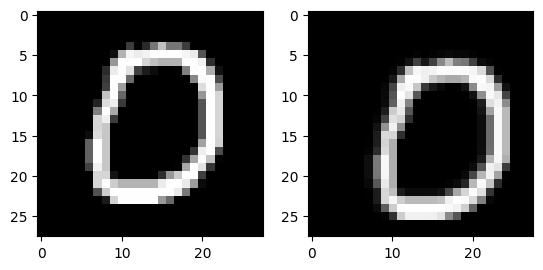

In [19]:
frac_conv_layer = FractionalConv2d(
                in_channels=1,              
                out_channels=1,            
                kernel_size=5,       
                stride=1,                   
                padding=2,                  
            )
visualize_conv(frac_conv_layer)

# CNN with pruning

## Model

In [20]:
class PrunedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True, sparsity=0.5):
        super(PrunedConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.sparsity = sparsity

        self.prune()

    def forward(self, x):
        return self.conv(x)

    def prune(self):
        prune.random_unstructured(self.conv, name="weight", amount=0.3)

    def get_sparsity(self):
        return self.sparsity

    def set_sparsity(self, sparsity):
        self.sparsity = sparsity
        self.prune()

In [21]:
class MNISTCNN_pruned(nn.Module):
    def __init__(self):
        super(MNISTCNN_pruned, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,          
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(
            PrunedConv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,             
                stride=1,                   
                padding=2,                  
            ),  
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x

## Training

In [22]:
cnn_pruned = MNISTCNN_pruned()
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_pruned.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_pruned, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:38<00:00, 15.53it/s]

Epoch [1/10], Loss: 0.1691



100%|██████████| 600/600 [00:38<00:00, 15.72it/s]

Epoch [2/10], Loss: 0.0665



100%|██████████| 600/600 [00:38<00:00, 15.69it/s]

Epoch [3/10], Loss: 0.0542



100%|██████████| 600/600 [00:37<00:00, 15.84it/s]

Epoch [4/10], Loss: 0.0493



100%|██████████| 600/600 [00:38<00:00, 15.64it/s]

Epoch [5/10], Loss: 0.0468



100%|██████████| 600/600 [00:38<00:00, 15.67it/s]

Epoch [6/10], Loss: 0.0438



100%|██████████| 600/600 [00:37<00:00, 15.81it/s]


Epoch [7/10], Loss: 0.0412


100%|██████████| 600/600 [00:38<00:00, 15.64it/s]

Epoch [8/10], Loss: 0.0437



100%|██████████| 600/600 [00:38<00:00, 15.73it/s]

Epoch [9/10], Loss: 0.0431



100%|██████████| 600/600 [00:38<00:00, 15.74it/s]

Epoch [10/10], Loss: 0.0441
Training time: 382


## Testing

In [23]:
test(cnn_pruned, loaders)

Precision on the 10000 test images: 0.9844
Recall on the 10000 test images: 0.9842
F1 score on the 10000 test images: 0.9842


## Visualization

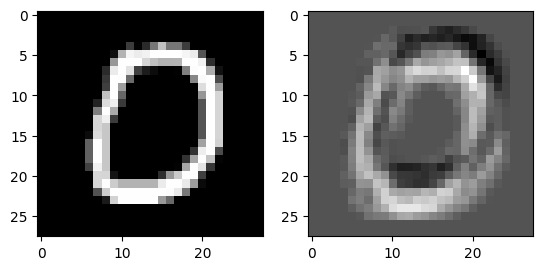

In [24]:
pruned_conv_layer = PrunedConv2d(
                in_channels=1,              
                out_channels=1,      
                kernel_size=5,       
                stride=1,                   
                padding=2,                  
            )
visualize_conv(pruned_conv_layer)

# CNN with Low-rank approximation

## Model

In [25]:
class LowRankConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, r=3, method='constant', decomposition='cur'):
        super(LowRankConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.r = r

        self.conv = nn.Conv2d(
                in_channels=self.in_channels,              
                out_channels=self.out_channels,            
                kernel_size=self.kernel_size,           
                stride=self.stride,                   
                padding=self.padding,                  
            )
        # print(self.conv.weight.shape)
        
        if decomposition == 'cur':
            if method == 'constant':
                c = 0.99
            elif method == 'log':
                c = np.log(self.conv.weight.shape[-1])
            self.conv.weight.data = torch.from_numpy(self.cur_low_rank(self.conv.weight, c=c, r=r))
        elif decomposition == 'svd':
            self.conv.weight.data = torch.from_numpy(self.traditional_low_rank(self.conv.weight, r=r))

        # print(self.conv.weight.shape)

    def forward(self, x):
        return self.conv(x)

    def traditional_low_rank(self, A, r):
        # A is a 4D weight matrix
        # k is the target rank
        A = A.detach().numpy()
        
        # Flatten the 4D weight matrix into a 2D matrix
        n1, n2, n3, n4 = A.shape
        A = A.reshape((n1*n2*n3, n4))

        # Compute the SVD of A
        U, s, Vt = svd(A, full_matrices=False)

        # Truncate the SVD to the target rank
        U = U[:, :r]
        s = s[:r]
        Vt = Vt[:r, :]

        # Compute the low-rank approximation
        A_approx = np.dot(U, np.dot(np.diag(s), Vt))

        # Reshape the low-rank approximation to a 4D weight matrix
        A_approx = A_approx.reshape((n1, n2, n3, n4))

        return A_approx

    def cur_low_rank(self, A, c, r):
        # Flatten the 4D weight matrix into a 2D matrix
        A = A.detach().numpy()
        n1, n2, n3, n4 = A.shape
        A_2d = A.reshape((n1*n2*n3, n4))
        m, n = A_2d.shape

        curr_r = np.linalg.matrix_rank(A_2d)
        
        # Computing C
        def choose_col_by_prob(A):
            U, s, Vt = svd(A, full_matrices=False)

            leverage_scores = np.linalg.norm(Vt[:curr_r], axis=0) ** 2 / curr_r
            column_probabilities = np.minimum(c, leverage_scores) / np.sum(np.minimum(c, leverage_scores))
            selected_columns = np.random.choice(A.shape[1], curr_r, replace=False, p=column_probabilities)
            
            return A[:, selected_columns]

        C = choose_col_by_prob(A_2d)
        R = choose_col_by_prob(np.transpose(A_2d))
        C_pinv = np.linalg.pinv(C)
        R_pinv = np.linalg.pinv(R)

        U = C_pinv @ A_2d @ R_pinv

        # Truncate the CUR to the target rank
        C = C[:, :r]
        U = U[:r, :r]
        R = R[:r, :]

        A_approx = C @ U @ R

        # Reshape the low-rank approximation to a 4D weight matrix
        A_approx = A_approx.reshape((n1, n2, n3, n4))
        return A_approx

In [26]:
class MNISTCNN_lowrank(nn.Module):
    def __init__(self, r=3, method='constant', decomposition='cur'):
        super(MNISTCNN_lowrank, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,          
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(
            LowRankConv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,             
                stride=1,                   
                padding=2, 
                r=r,
                method=method,
                decomposition = decomposition                
            ),  
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x

## Training & Testing

### SVD

In [27]:
cnn_lowrank_svd_0 = MNISTCNN_lowrank(r=5, decomposition='svd')
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_lowrank_svd_0.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_lowrank_svd_0, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:37<00:00, 16.01it/s]

Epoch [1/10], Loss: 0.1422



100%|██████████| 600/600 [00:37<00:00, 15.90it/s]

Epoch [2/10], Loss: 0.0566



100%|██████████| 600/600 [00:37<00:00, 15.83it/s]

Epoch [3/10], Loss: 0.0453



100%|██████████| 600/600 [00:38<00:00, 15.76it/s]

Epoch [4/10], Loss: 0.0447



100%|██████████| 600/600 [00:37<00:00, 15.87it/s]

Epoch [5/10], Loss: 0.0424



100%|██████████| 600/600 [00:37<00:00, 15.83it/s]

Epoch [6/10], Loss: 0.0400



100%|██████████| 600/600 [00:37<00:00, 16.20it/s]

Epoch [7/10], Loss: 0.0341



100%|██████████| 600/600 [00:36<00:00, 16.27it/s]

Epoch [8/10], Loss: 0.0408



100%|██████████| 600/600 [00:37<00:00, 15.92it/s]

Epoch [9/10], Loss: 0.0370



100%|██████████| 600/600 [00:37<00:00, 15.89it/s]

Epoch [10/10], Loss: 0.0370
Training time: 376


In [28]:
cnn_lowrank_svd_1 = MNISTCNN_lowrank(r=4, decomposition='svd')
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_lowrank_svd_1.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_lowrank_svd_1, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:37<00:00, 15.92it/s]

Epoch [1/10], Loss: 0.1897



100%|██████████| 600/600 [00:38<00:00, 15.78it/s]

Epoch [2/10], Loss: 0.0726



100%|██████████| 600/600 [00:37<00:00, 15.80it/s]

Epoch [3/10], Loss: 0.0612



100%|██████████| 600/600 [00:37<00:00, 15.85it/s]

Epoch [4/10], Loss: 0.0571



100%|██████████| 600/600 [00:37<00:00, 15.98it/s]

Epoch [5/10], Loss: 0.0542



100%|██████████| 600/600 [00:38<00:00, 15.77it/s]

Epoch [6/10], Loss: 0.0496



100%|██████████| 600/600 [00:37<00:00, 15.85it/s]

Epoch [7/10], Loss: 0.0521



100%|██████████| 600/600 [00:37<00:00, 15.79it/s]

Epoch [8/10], Loss: 0.0497



100%|██████████| 600/600 [00:38<00:00, 15.79it/s]

Epoch [9/10], Loss: 0.0483



100%|██████████| 600/600 [00:37<00:00, 15.84it/s]

Epoch [10/10], Loss: 0.0553
Training time: 379


In [29]:
cnn_lowrank_svd_2 = MNISTCNN_lowrank(r=3, decomposition='svd')
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_lowrank_svd_2.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_lowrank_svd_2, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:38<00:00, 15.61it/s]

Epoch [1/10], Loss: 0.1404



100%|██████████| 600/600 [00:38<00:00, 15.67it/s]

Epoch [2/10], Loss: 0.0571



100%|██████████| 600/600 [00:37<00:00, 15.95it/s]

Epoch [3/10], Loss: 0.0470



100%|██████████| 600/600 [00:37<00:00, 16.02it/s]

Epoch [4/10], Loss: 0.0419



100%|██████████| 600/600 [00:36<00:00, 16.27it/s]

Epoch [5/10], Loss: 0.0419



100%|██████████| 600/600 [00:36<00:00, 16.34it/s]

Epoch [6/10], Loss: 0.0419



100%|██████████| 600/600 [00:37<00:00, 16.15it/s]

Epoch [7/10], Loss: 0.0366



100%|██████████| 600/600 [00:37<00:00, 16.13it/s]

Epoch [8/10], Loss: 0.0382



100%|██████████| 600/600 [00:36<00:00, 16.23it/s]

Epoch [9/10], Loss: 0.0370



100%|██████████| 600/600 [00:37<00:00, 16.11it/s]

Epoch [10/10], Loss: 0.0363
Training time: 374


In [30]:
cnn_lowrank_svd_3 = MNISTCNN_lowrank(r=2, decomposition='svd')
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_lowrank_svd_3.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_lowrank_svd_3, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:37<00:00, 16.04it/s]

Epoch [1/10], Loss: 0.1585



100%|██████████| 600/600 [00:37<00:00, 15.99it/s]

Epoch [2/10], Loss: 0.0622



100%|██████████| 600/600 [00:37<00:00, 16.06it/s]

Epoch [3/10], Loss: 0.0511



100%|██████████| 600/600 [00:37<00:00, 15.93it/s]

Epoch [4/10], Loss: 0.0461



100%|██████████| 600/600 [00:37<00:00, 16.19it/s]

Epoch [5/10], Loss: 0.0456



100%|██████████| 600/600 [00:36<00:00, 16.24it/s]

Epoch [6/10], Loss: 0.0418



100%|██████████| 600/600 [00:36<00:00, 16.32it/s]

Epoch [7/10], Loss: 0.0408



100%|██████████| 600/600 [00:37<00:00, 15.98it/s]

Epoch [8/10], Loss: 0.0394



100%|██████████| 600/600 [00:36<00:00, 16.25it/s]

Epoch [9/10], Loss: 0.0386



100%|██████████| 600/600 [00:37<00:00, 16.00it/s]

Epoch [10/10], Loss: 0.0413
Training time: 373


In [31]:
test(cnn_lowrank_svd_0, loaders)

Precision on the 10000 test images: 0.9831
Recall on the 10000 test images: 0.9829
F1 score on the 10000 test images: 0.9829


In [32]:
test(cnn_lowrank_svd_1, loaders)

Precision on the 10000 test images: 0.9789
Recall on the 10000 test images: 0.9787
F1 score on the 10000 test images: 0.9787


In [33]:
test(cnn_lowrank_svd_2, loaders)

Precision on the 10000 test images: 0.9856
Recall on the 10000 test images: 0.9854
F1 score on the 10000 test images: 0.9854


In [34]:
test(cnn_lowrank_svd_3, loaders)

Precision on the 10000 test images: 0.9846
Recall on the 10000 test images: 0.9845
F1 score on the 10000 test images: 0.9845


### CUR c = ln(n)

In [35]:
cnn_lowrank_cur_log_0 = MNISTCNN_lowrank(r=5, method='log', decomposition='cur')
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_lowrank_cur_log_0.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_lowrank_cur_log_0, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:37<00:00, 15.91it/s]

Epoch [1/10], Loss: 0.1922



100%|██████████| 600/600 [00:37<00:00, 16.02it/s]

Epoch [2/10], Loss: 0.0704



100%|██████████| 600/600 [00:37<00:00, 16.01it/s]

Epoch [3/10], Loss: 0.0590



100%|██████████| 600/600 [00:37<00:00, 16.18it/s]

Epoch [4/10], Loss: 0.0544



100%|██████████| 600/600 [00:37<00:00, 16.00it/s]

Epoch [5/10], Loss: 0.0519



100%|██████████| 600/600 [00:37<00:00, 15.97it/s]

Epoch [6/10], Loss: 0.0486



100%|██████████| 600/600 [00:36<00:00, 16.47it/s]

Epoch [7/10], Loss: 0.0482



100%|██████████| 600/600 [00:36<00:00, 16.30it/s]

Epoch [8/10], Loss: 0.0442



100%|██████████| 600/600 [00:37<00:00, 16.07it/s]

Epoch [9/10], Loss: 0.0450



100%|██████████| 600/600 [00:37<00:00, 16.16it/s]

Epoch [10/10], Loss: 0.0451
Training time: 373


In [36]:
cnn_lowrank_cur_log_1 = MNISTCNN_lowrank(r=4, method='log', decomposition='cur')
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_lowrank_cur_log_1.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_lowrank_cur_log_1, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:37<00:00, 15.97it/s]

Epoch [1/10], Loss: 0.2402



100%|██████████| 600/600 [00:37<00:00, 16.21it/s]

Epoch [2/10], Loss: 0.0783



100%|██████████| 600/600 [00:37<00:00, 16.03it/s]


Epoch [3/10], Loss: 0.0650


100%|██████████| 600/600 [00:37<00:00, 16.11it/s]

Epoch [4/10], Loss: 0.0620



100%|██████████| 600/600 [00:37<00:00, 16.14it/s]

Epoch [5/10], Loss: 0.0571



100%|██████████| 600/600 [00:37<00:00, 16.11it/s]


Epoch [6/10], Loss: 0.0582


100%|██████████| 600/600 [00:36<00:00, 16.33it/s]

Epoch [7/10], Loss: 0.0559



100%|██████████| 600/600 [00:36<00:00, 16.39it/s]

Epoch [8/10], Loss: 0.0535



100%|██████████| 600/600 [00:37<00:00, 16.10it/s]

Epoch [9/10], Loss: 0.0556



100%|██████████| 600/600 [00:37<00:00, 16.16it/s]

Epoch [10/10], Loss: 0.0525
Training time: 371


In [37]:
cnn_lowrank_cur_log_2 = MNISTCNN_lowrank(r=3, method='log', decomposition='cur')
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_lowrank_cur_log_2.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_lowrank_cur_log_2, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:36<00:00, 16.23it/s]

Epoch [1/10], Loss: 0.1663



100%|██████████| 600/600 [00:37<00:00, 16.07it/s]

Epoch [2/10], Loss: 0.0632



100%|██████████| 600/600 [00:36<00:00, 16.23it/s]

Epoch [3/10], Loss: 0.0555



100%|██████████| 600/600 [00:37<00:00, 16.10it/s]

Epoch [4/10], Loss: 0.0513



100%|██████████| 600/600 [00:37<00:00, 16.16it/s]

Epoch [5/10], Loss: 0.0460



100%|██████████| 600/600 [00:36<00:00, 16.28it/s]

Epoch [6/10], Loss: 0.0463



100%|██████████| 600/600 [00:35<00:00, 16.83it/s]

Epoch [7/10], Loss: 0.0417



100%|██████████| 600/600 [00:36<00:00, 16.28it/s]

Epoch [8/10], Loss: 0.0419



100%|██████████| 600/600 [00:37<00:00, 16.16it/s]

Epoch [9/10], Loss: 0.0433



100%|██████████| 600/600 [00:36<00:00, 16.22it/s]

Epoch [10/10], Loss: 0.0430
Training time: 369


In [38]:
cnn_lowrank_cur_log_3 = MNISTCNN_lowrank(r=2, method='log', decomposition='cur')
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_lowrank_cur_log_3.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_lowrank_cur_log_3, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:37<00:00, 16.13it/s]

Epoch [1/10], Loss: 0.1258



100%|██████████| 600/600 [00:37<00:00, 16.13it/s]

Epoch [2/10], Loss: 0.0525



100%|██████████| 600/600 [00:37<00:00, 16.14it/s]

Epoch [3/10], Loss: 0.0438



100%|██████████| 600/600 [00:36<00:00, 16.28it/s]

Epoch [4/10], Loss: 0.0396



100%|██████████| 600/600 [00:36<00:00, 16.37it/s]

Epoch [5/10], Loss: 0.0408



100%|██████████| 600/600 [00:36<00:00, 16.46it/s]

Epoch [6/10], Loss: 0.0377



100%|██████████| 600/600 [00:36<00:00, 16.26it/s]

Epoch [7/10], Loss: 0.0329



100%|██████████| 600/600 [00:37<00:00, 16.05it/s]

Epoch [8/10], Loss: 0.0375



100%|██████████| 600/600 [00:36<00:00, 16.43it/s]

Epoch [9/10], Loss: 0.0363



100%|██████████| 600/600 [00:35<00:00, 16.72it/s]

Epoch [10/10], Loss: 0.0362
Training time: 368


In [39]:
test(cnn_lowrank_cur_log_0, loaders)

Precision on the 10000 test images: 0.9848
Recall on the 10000 test images: 0.9848
F1 score on the 10000 test images: 0.9848


In [40]:
test(cnn_lowrank_cur_log_1, loaders)

Precision on the 10000 test images: 0.9835
Recall on the 10000 test images: 0.9834
F1 score on the 10000 test images: 0.9834


In [41]:
test(cnn_lowrank_cur_log_2, loaders)

Precision on the 10000 test images: 0.9847
Recall on the 10000 test images: 0.9847
F1 score on the 10000 test images: 0.9847


In [42]:
test(cnn_lowrank_cur_log_3, loaders)

Precision on the 10000 test images: 0.9855
Recall on the 10000 test images: 0.9854
F1 score on the 10000 test images: 0.9854


### CUR c = 0.1

In [43]:
cnn_lowrank_cur_const_0 = MNISTCNN_lowrank(r=5, method='constant', decomposition='cur')
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_lowrank_cur_const_0.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_lowrank_cur_const_0, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:35<00:00, 16.78it/s]

Epoch [1/10], Loss: 0.1397



100%|██████████| 600/600 [00:34<00:00, 17.53it/s]

Epoch [2/10], Loss: 0.0521



100%|██████████| 600/600 [00:34<00:00, 17.27it/s]

Epoch [3/10], Loss: 0.0462



100%|██████████| 600/600 [00:34<00:00, 17.23it/s]

Epoch [4/10], Loss: 0.0438



100%|██████████| 600/600 [00:35<00:00, 17.00it/s]

Epoch [5/10], Loss: 0.0410



100%|██████████| 600/600 [00:34<00:00, 17.36it/s]

Epoch [6/10], Loss: 0.0401



100%|██████████| 600/600 [00:34<00:00, 17.15it/s]

Epoch [7/10], Loss: 0.0393



100%|██████████| 600/600 [00:35<00:00, 17.13it/s]

Epoch [8/10], Loss: 0.0375



100%|██████████| 600/600 [00:35<00:00, 16.89it/s]

Epoch [9/10], Loss: 0.0387



100%|██████████| 600/600 [00:34<00:00, 17.22it/s]

Epoch [10/10], Loss: 0.0427
Training time: 350


In [44]:
cnn_lowrank_cur_const_1 = MNISTCNN_lowrank(r=4, method='constant', decomposition='cur')
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_lowrank_cur_const_1.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_lowrank_cur_const_1, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:36<00:00, 16.67it/s]

Epoch [1/10], Loss: 0.1281



100%|██████████| 600/600 [00:35<00:00, 16.81it/s]

Epoch [2/10], Loss: 0.0518



100%|██████████| 600/600 [00:34<00:00, 17.15it/s]

Epoch [3/10], Loss: 0.0462



100%|██████████| 600/600 [00:33<00:00, 17.77it/s]

Epoch [4/10], Loss: 0.0402



100%|██████████| 600/600 [00:35<00:00, 17.08it/s]

Epoch [5/10], Loss: 0.0418



100%|██████████| 600/600 [00:34<00:00, 17.26it/s]

Epoch [6/10], Loss: 0.0408



100%|██████████| 600/600 [00:41<00:00, 14.30it/s]

Epoch [7/10], Loss: 0.0392



100%|██████████| 600/600 [00:35<00:00, 16.99it/s]

Epoch [8/10], Loss: 0.0356



100%|██████████| 600/600 [00:36<00:00, 16.54it/s]

Epoch [9/10], Loss: 0.0345



100%|██████████| 600/600 [00:35<00:00, 16.76it/s]

Epoch [10/10], Loss: 0.0316
Training time: 360


In [45]:
cnn_lowrank_cur_const_2 = MNISTCNN_lowrank(r=3, method='constant', decomposition='cur')
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_lowrank_cur_const_2.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_lowrank_cur_const_2, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:34<00:00, 17.43it/s]

Epoch [1/10], Loss: 0.1197



100%|██████████| 600/600 [00:35<00:00, 17.03it/s]

Epoch [2/10], Loss: 0.0519



100%|██████████| 600/600 [00:35<00:00, 16.82it/s]

Epoch [3/10], Loss: 0.0465



100%|██████████| 600/600 [00:35<00:00, 16.86it/s]

Epoch [4/10], Loss: 0.0440



100%|██████████| 600/600 [00:35<00:00, 17.11it/s]

Epoch [5/10], Loss: 0.0401



100%|██████████| 600/600 [00:34<00:00, 17.22it/s]

Epoch [6/10], Loss: 0.0365



100%|██████████| 600/600 [00:35<00:00, 16.93it/s]

Epoch [7/10], Loss: 0.0353



100%|██████████| 600/600 [00:35<00:00, 16.92it/s]

Epoch [8/10], Loss: 0.0442



100%|██████████| 600/600 [00:35<00:00, 16.87it/s]

Epoch [9/10], Loss: 0.0355



100%|██████████| 600/600 [00:34<00:00, 17.63it/s]

Epoch [10/10], Loss: 0.0395
Training time: 351


In [46]:
cnn_lowrank_cur_const_3 = MNISTCNN_lowrank(r=2, method='constant', decomposition='cur')
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_lowrank_cur_const_3.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_lowrank_cur_const_3, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:35<00:00, 16.98it/s]

Epoch [1/10], Loss: 0.1663



100%|██████████| 600/600 [00:34<00:00, 17.15it/s]

Epoch [2/10], Loss: 0.0663



100%|██████████| 600/600 [00:35<00:00, 17.07it/s]

Epoch [3/10], Loss: 0.0554



100%|██████████| 600/600 [00:34<00:00, 17.52it/s]

Epoch [4/10], Loss: 0.0509



100%|██████████| 600/600 [00:34<00:00, 17.14it/s]

Epoch [5/10], Loss: 0.0480



100%|██████████| 600/600 [00:35<00:00, 16.99it/s]

Epoch [6/10], Loss: 0.0440



100%|██████████| 600/600 [00:34<00:00, 17.18it/s]

Epoch [7/10], Loss: 0.0454



100%|██████████| 600/600 [00:34<00:00, 17.42it/s]


Epoch [8/10], Loss: 0.0428


100%|██████████| 600/600 [00:34<00:00, 17.27it/s]

Epoch [9/10], Loss: 0.0422



100%|██████████| 600/600 [00:34<00:00, 17.15it/s]

Epoch [10/10], Loss: 0.0434
Training time: 349


In [47]:
test(cnn_lowrank_cur_const_0, loaders)

Precision on the 10000 test images: 0.9812
Recall on the 10000 test images: 0.9810
F1 score on the 10000 test images: 0.9810


In [48]:
test(cnn_lowrank_cur_const_1, loaders)

Precision on the 10000 test images: 0.9857
Recall on the 10000 test images: 0.9856
F1 score on the 10000 test images: 0.9856


In [49]:
test(cnn_lowrank_cur_const_2, loaders)

Precision on the 10000 test images: 0.9740
Recall on the 10000 test images: 0.9731
F1 score on the 10000 test images: 0.9731


In [50]:
test(cnn_lowrank_cur_const_3, loaders)

Precision on the 10000 test images: 0.9838
Recall on the 10000 test images: 0.9837
F1 score on the 10000 test images: 0.9837


## Visualization

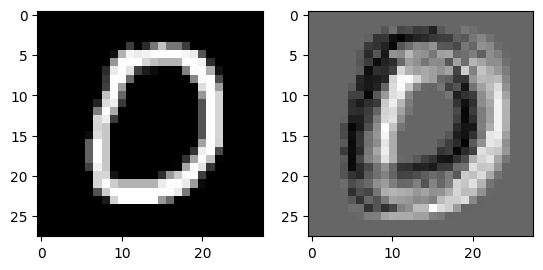

In [51]:
lowrank_conv_layer = LowRankConv2d(
                in_channels=1,              
                out_channels=1,            
                kernel_size=5,       
                stride=1,                   
                padding=2,                  
            )
visualize_conv(lowrank_conv_layer)

# Visualization for all

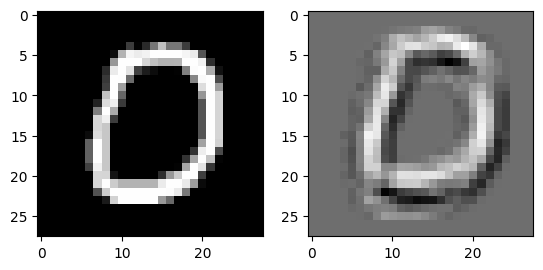

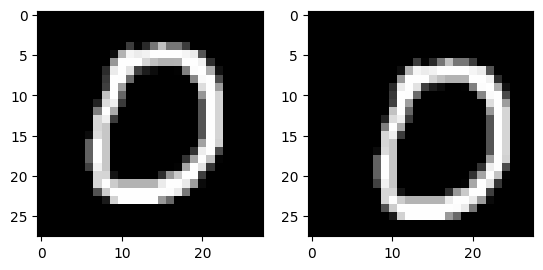

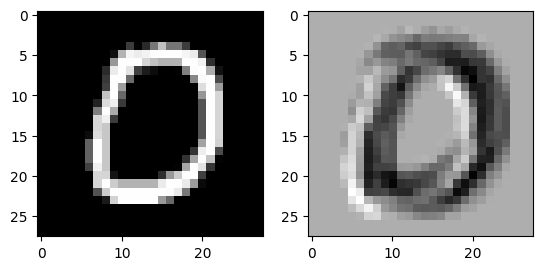

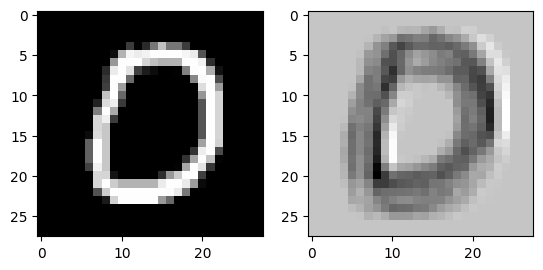

In [52]:
conv_layer = nn.Conv2d(
                in_channels=1,              
                out_channels=1,            
                kernel_size=5,       
                stride=1,                   
                padding=2,                  
            )
visualize_conv(conv_layer)

frac_conv_layer = FractionalConv2d(
                in_channels=1,              
                out_channels=1,            
                kernel_size=5,       
                stride=1,                   
                padding=2,                  
            )
visualize_conv(frac_conv_layer)

pruned_conv_layer = PrunedConv2d(
                in_channels=1,              
                out_channels=1,            
                kernel_size=5,       
                stride=1,                   
                padding=2,                  
            )
visualize_conv(pruned_conv_layer)

lowrank_conv_layer = LowRankConv2d(
                in_channels=1,              
                out_channels=1,            
                kernel_size=5,       
                stride=1,                   
                padding=2,                  
            )
visualize_conv(lowrank_conv_layer)

# Count parameters for all

In [53]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [54]:
cnn_params = count_parameters(cnn)

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| conv1.0.weight |    400     |
|  conv1.0.bias  |     16     |
| conv2.0.weight |   12800    |
|  conv2.0.bias  |     32     |
|   out.weight   |   15680    |
|    out.bias    |     10     |
+----------------+------------+
Total Trainable Params: 28938


In [55]:
cnn_frac_params = count_parameters(cnn_frac)

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| conv1.0.weight |    400     |
|  conv1.0.bias  |     16     |
|   conv2.0.A    |    512     |
| conv2.0.sigma  |    512     |
|   conv2.0.x0   |    512     |
|   conv2.0.y0   |    512     |
|   conv2.0.a    |    512     |
|   conv2.0.b    |    512     |
|   out.weight   |   15680    |
|    out.bias    |     10     |
+----------------+------------+
Total Trainable Params: 19178


In [56]:
from prettytable import PrettyTable

def count_parameters_pruning(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        
        param = parameter.numel()
        if 'conv.weight_orig' in name:
            pruned_mask = list(model.conv2.named_buffers())
            param = int(torch.sum(pruned_mask[0][1]).item())
            name = name[:-5]
        
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


In [57]:
cnn_pruned_params = count_parameters_pruning(cnn_pruned)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|    conv1.0.weight   |    400     |
|     conv1.0.bias    |     16     |
|  conv2.0.conv.bias  |     32     |
| conv2.0.conv.weight |    8960    |
|      out.weight     |   15680    |
|       out.bias      |     10     |
+---------------------+------------+
Total Trainable Params: 25098


In [59]:
cnn_lowrank_params = count_parameters(cnn_lowrank_svd_0)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|    conv1.0.weight   |    400     |
|     conv1.0.bias    |     16     |
| conv2.0.conv.weight |   12800    |
|  conv2.0.conv.bias  |     32     |
|      out.weight     |   15680    |
|       out.bias      |     10     |
+---------------------+------------+
Total Trainable Params: 28938
